In [1]:
import pandas as pd
import cupy as cp
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import pylab
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, FixedLocator
from matplotlib.widgets import Cursor
import seaborn as sns
from scipy.stats import skew as skew

from numba import jit, cuda, njit, prange
from timeit import default_timer as timer
import time

In [2]:
dt = .001
tau = .1
noise_tau = .002
w11, w22 = 1, 1
w21, w12 = 1, 1
dur = 5
bifurcate_time = 0
threshold = 70
S = 576
R_initial = 42
sgm = 10
eta = S*0


In [3]:
@njit(parallel=True, fastmath=True)
def ave_choice(coh, a, b, V_size):

    alpha = a

    beta = 0
    V_matrix = np.zeros(V_size)
    V_matrix.fill(S)

    omega_matrix = np.zeros((V_size, V_size))
    omega_matrix.fill(1)

    R_matrix = np.zeros((V_size, int(dur/dt)))
    G_matrix = np.zeros((V_size, int(dur/dt)))
    D_matrix = np.zeros((V_size, int(dur/dt)))

    R_matrix[:, 0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(np.sum(omega_matrix, axis=1)-beta))) / (2*(np.sum(omega_matrix, axis=1)-beta))
    G_matrix[:, 0] = (np.sum(omega_matrix, axis=1) - beta) * R_matrix[:, 0]
    D_matrix[:, 0] = beta * R_matrix[:, 0]

    noise_R = np.zeros((V_size, int(dur/dt)))
    noise_G = np.zeros((V_size, int(dur/dt)))
    noise_D = np.zeros((V_size, int(dur/dt)))

    rep = 10240
    reaction_time = np.zeros(rep)
    choice = np.zeros(rep)

    for i in prange(rep):

        beta = 0
        V_matrix.fill(S)

        for ti in range(1, int(dur/dt)):

            if ti == bifurcate_time/dt:
                beta = b
                V_matrix[0] = S * (1+coh)
                V_matrix[1:] = S * (1-coh)

            if ti >= bifurcate_time/dt and ti % 5 == 0:
                V_matrix[0] = S * (1+coh) + np.random.randn() * eta
                V_matrix[1:] = S * (1-coh) + np.random.randn() * eta

            d_noise_R = (-noise_R[:, ti-1] + np.random.randn(V_size) * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noise_G = (-noise_G[:, ti-1] + np.random.randn(V_size) * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noise_D = (-noise_D[:, ti-1] + np.random.randn(V_size) * np.sqrt(dt) * sgm) / noise_tau*dt

            d_R = (-R_matrix[:, ti-1] + (alpha * R_matrix[:, ti-1] + V_matrix) / (1+G_matrix[:, ti-1])) * dt/tau
            d_G = (-G_matrix[:, ti-1] - D_matrix[:, ti-1] + omega_matrix @ R_matrix[:, ti-1])* dt/tau
            d_D = (-D_matrix[:, ti-1] + beta * R_matrix[:, ti-1]) * dt/tau

            # d_R1 = (-R_matrix[0][ti-1] + (alpha * R_matrix[0][ti-1] + V_matrix[0]) / (1 + G_matrix[0][ti-1])) * dt/tau
            # d_R2 = (-R_matrix[1][ti-1] + (alpha * R_matrix[1][ti-1] + V_matrix[1]) / (1 + G_matrix[1][ti-1])) * dt/tau
            # d_R = np.array([d_R1, d_R2])
            #
            # d_G1 = (-G_matrix[0][ti-1] + R_matrix[0][ti-1] + R_matrix[1][ti-1] - D_matrix[0][ti-1]) * dt/tau
            # d_G2 = (-G_matrix[1][ti-1] + R_matrix[0][ti-1] + R_matrix[1][ti-1] - D_matrix[1][ti-1]) * dt/tau
            # d_G = np.array([d_G1, d_G2])
            #
            # d_D1 = (-D_matrix[0][ti-1] + beta*R_matrix[0][ti-1]) *dt/tau
            # d_D2 = (-D_matrix[1][ti-1] + beta*R_matrix[1][ti-1]) *dt/tau
            # d_D = np.array([d_D1, d_D2])

            noise_R[:, ti] = noise_R[:, ti-1] + d_noise_R
            noise_G[:, ti] = noise_G[:, ti-1] + d_noise_G
            noise_D[:, ti] = noise_D[:, ti-1] + d_noise_D

            R_matrix[:, ti] = np.maximum(R_matrix[:, ti-1] + d_R + noise_R[:, ti], 0)
            G_matrix[:, ti] = np.maximum(G_matrix[:, ti-1] + d_G + noise_G[:, ti], 0)
            D_matrix[:, ti] = np.maximum(D_matrix[:, ti-1] + d_D + noise_D[:, ti], 0)

            if R_matrix[0, ti] > threshold and ti >= bifurcate_time/dt:
                choice[i] = 1
                reaction_time[i] = ti - bifurcate_time/dt
                break
            # elif True in (R_matrix[:, ti] > threshold) and ti >= bifurcate_time/dt:
            elif R_matrix[1, ti] > threshold and ti >= bifurcate_time/dt:
                reaction_time[i] = ti - bifurcate_time/dt
                break
            elif ti == dur/dt-1:
                reaction_time[i] = np.NAN
                choice[i] = np.NAN

    return reaction_time, choice


In [4]:
def clean_bg(axes):
    for ax_row in axes:
        for ax in ax_row:
            ax.tick_params(axis='x', direction="in")
            ax.tick_params(axis="y", direction="in")
            ax.tick_params(bottom=True, left=True)
            ax.spines['bottom'].set_color('0')
            ax.spines['left'].set_color('0')
            ax.patch.set_facecolor('white')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            font_size = 20
            params = {'figure.figsize': (7, 6),
                     'legend.fontsize': font_size,
                     'axes.labelsize': font_size,
                     'axes.titlesize': font_size,
                     'xtick.labelsize': font_size,
                     'ytick.labelsize': font_size}
            pylab.rcParams.update(params)
            plt.grid(False)


In [5]:
alpha_array = np.linspace(10, 80, 5)
beta_array = np.linspace(1, 2., 5)


C:\Users\weiyi\AppData\Local\Temp\ipykernel_22932\252531494.py:50: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  d_G = (-G_matrix[:, ti-1] - D_matrix[:, ti-1] + omega_matrix @ R_matrix[:, ti-1])* dt/tau
C:\Users\weiyi\AppData\Local\Temp\ipykernel_22932\252531494.py:50: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  d_G = (-G_matrix[:, ti-1] - D_matrix[:, ti-1] + omega_matrix @ R_matrix[:, ti-1])* dt/tau
C:\Users\weiyi\anaconda3\envs\LDDM\lib\site-packages\numba\core\typing\npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


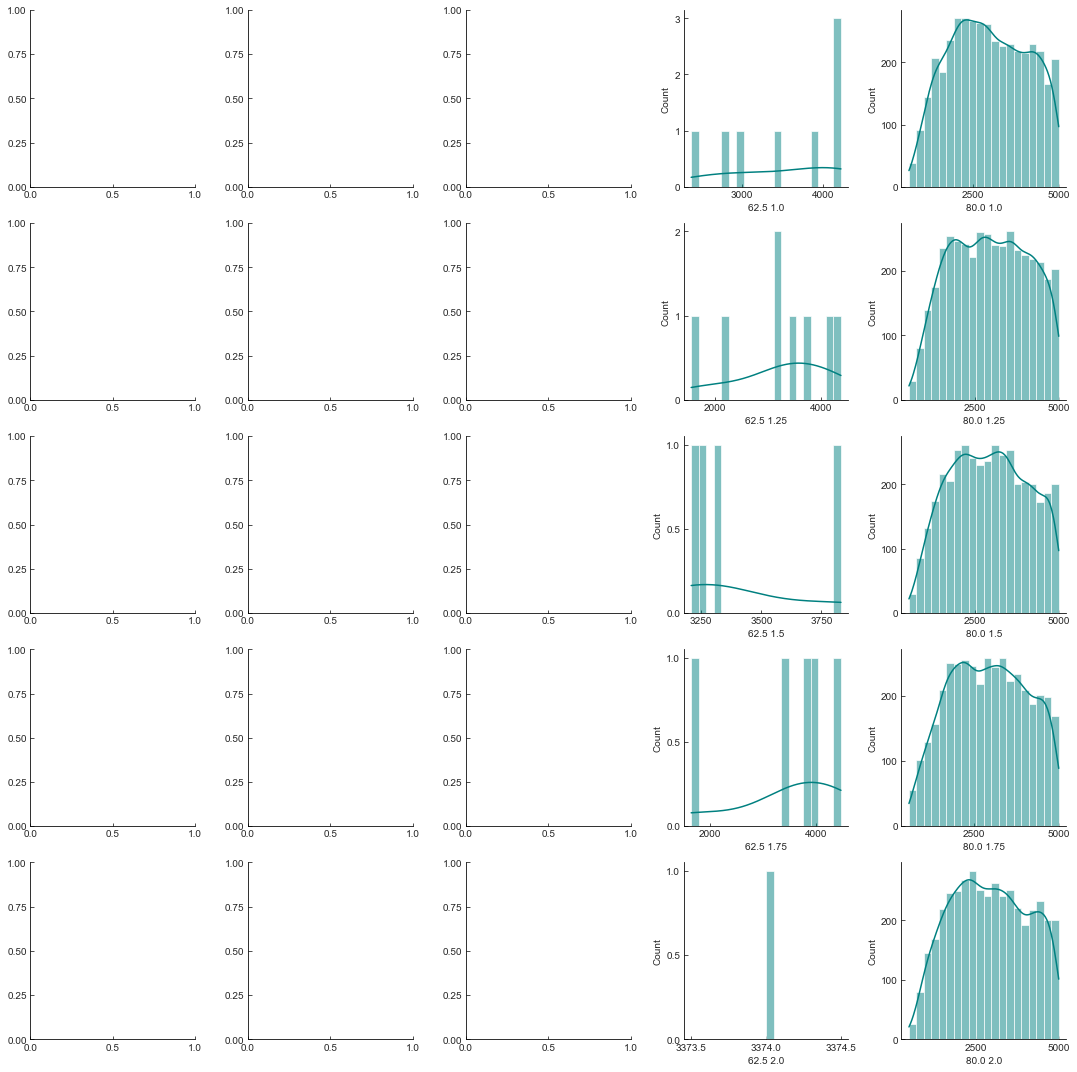

In [6]:
fig, ax = plt.subplots(5,5, figsize=(15, 15))
clean_bg(ax)
for col in range(5):
    for row in range(5):
        if row == col == 0:
            continue
        cur_RT, _ = ave_choice(.256, alpha_array[col], beta_array[row], 2)
        title = str(alpha_array[col])+" "+str(beta_array[row])
        df = pd.DataFrame(cur_RT, columns=[title])
        df = df[(df[title].quantile(.001) < df[title]) & (df[title] < df[title].quantile(.999))]
        sns.histplot(data=df, x=title, bins=20, color="teal", kde=True, ax=ax[row][col])

        # bins = np.arange(min(cur_RT), max(cur_RT), 25)
        # ax[row][col].hist(cur_RT, bins=bins)


plt.tight_layout()
plt.savefig("t")
